### Importing required libaries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
from tqdm.notebook import tqdm
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from models.old_model import SiameseNetwork

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine
from losses.triplet import TripletLoss

from utils.vis_utils import imshow, show_plot
from utils.other_utils import joinpath, SiameseNetworkDataset, SiameseNetworkDataset_for_test, get_dataset
from utils.other_utils import intersection, threshold, TripletDataset


In [2]:
# Setup the path where images are located
PATH = r"/Users/paligonshik/Desktop/Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning/data/faces"


# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=1

# no of epoch
EPOCH = 1

# if testing
testing = False

# Threshold score
THRESHOLD_SCORE = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [3]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])

transformation_for_test = transforms.Compose([transforms.Resize((100,100)),
    transforms.ToTensor(), 
    transforms.RandomApply([
         transforms.RandomRotation([-180,180])], p = 0.2)
])

In [4]:
os.cpu_count() #cpu count

10

For simple visualization purposes let’s look at this example.  
Create a DataLoader of the siamese_dataset and extract the first batch only.  
Combine each combination of images, because our siamese_datasetwill return two images and one label, and print out the labels.

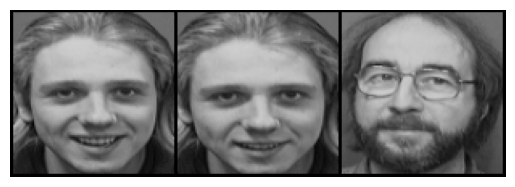

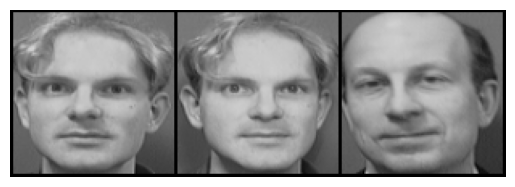

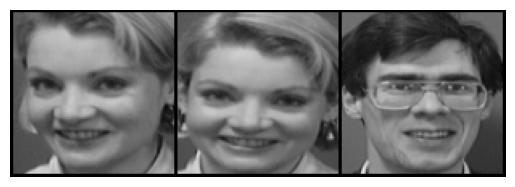

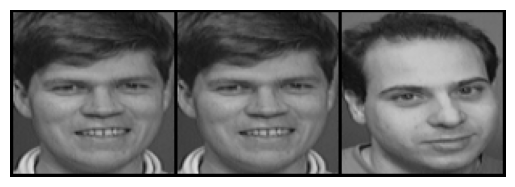

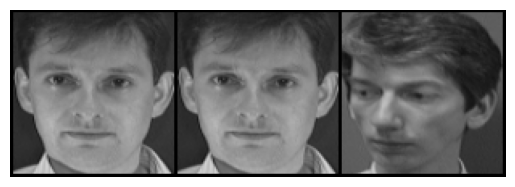

In [5]:
vis_triplet_dataloader,_ =  get_dataset(joinpath(PATH,'train'),transformation,TripletDataset,0,1,True)
for i in range(5):
    example_batch = next(iter(vis_triplet_dataloader))
    images = torch.cat((example_batch[0], example_batch[1], example_batch[2]), dim=0)
    # display the concatenated images
    imshow(torchvision.utils.make_grid(images, nrow=10))
    


In [6]:
train_loader,_ = get_dataset(joinpath(PATH,'train'),transformation,TripletDataset,0,64,True)

In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [13]:
# class Network(nn.Module):
#     def __init__(self, emb_dim=128):
#         super(Network, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 32, 5),
#             nn.PReLU(),
#             nn.MaxPool2d(2, stride=2),
#             nn.Dropout(0.3),
#             nn.Conv2d(32, 64, 5),
#             nn.PReLU(),
#             nn.MaxPool2d(2, stride=2),
#             nn.Dropout(0.3)
#         )
        
#         self.fc = nn.Sequential(
#             nn.Linear(64*4*4, 512),
#             nn.PReLU(),
#             nn.Linear(512, emb_dim)
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(-1, 64*4*4)
#         x = self.fc(x)
#         # x = nn.functional.normalize(x)
#         return x

class SiameseNetwork(nn.Module):

    def __init__(self, nchannel):
        super(SiameseNetwork, self).__init__()
        self.nchannel = nchannel

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(self.nchannel, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,128)
        )

    def forward_once(self, x):
        x = self.cnn1(x)
        
        x = x.view(-1, 384)
        x = self.fc1(x)
            # x = nn.functional.normalize(x)
        return x
    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [14]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [15]:
# embedding_dims = 128
model = SiameseNetwork(nchannel=1)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())


In [16]:

EPOCHS=50
model.train()
losses = []
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label,_,_) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model.forward_once(anchor_img)
        positive_out = model.forward_once(positive_img)
        negative_out = model.forward_once(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    losses.append(np.mean(running_loss))
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 0.5973


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.3044


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.2210


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.2633


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.1983


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.1462


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.1460


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.1665


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.1220


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.1210


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11/50 - Loss: 0.1144


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12/50 - Loss: 0.0393


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13/50 - Loss: 0.0968


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14/50 - Loss: 0.1120


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15/50 - Loss: 0.0897


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16/50 - Loss: 0.0618


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17/50 - Loss: 0.0373


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18/50 - Loss: 0.0582


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19/50 - Loss: 0.0532


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 20/50 - Loss: 0.0209


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 21/50 - Loss: 0.0524


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 22/50 - Loss: 0.1103


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 23/50 - Loss: 0.0649


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 24/50 - Loss: 0.0610


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 25/50 - Loss: 0.0427


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 26/50 - Loss: 0.0644


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 27/50 - Loss: 0.1836


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 28/50 - Loss: 0.1036


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 29/50 - Loss: 0.1221


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 30/50 - Loss: 0.1137


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 31/50 - Loss: 0.0615


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 32/50 - Loss: 0.0416


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 33/50 - Loss: 0.0655


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 34/50 - Loss: 0.0483


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 35/50 - Loss: 0.0298


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 36/50 - Loss: 0.0566


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 37/50 - Loss: 0.0477


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 38/50 - Loss: 0.0405


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 39/50 - Loss: 0.0416


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 40/50 - Loss: 0.0657


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 41/50 - Loss: 0.0485


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 42/50 - Loss: 0.0402


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 43/50 - Loss: 0.0446


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 44/50 - Loss: 0.0268


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 45/50 - Loss: 0.0346


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 46/50 - Loss: 0.0110


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 47/50 - Loss: 0.0244


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 48/50 - Loss: 0.0214


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 49/50 - Loss: 0.0038


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 50/50 - Loss: 0.0248


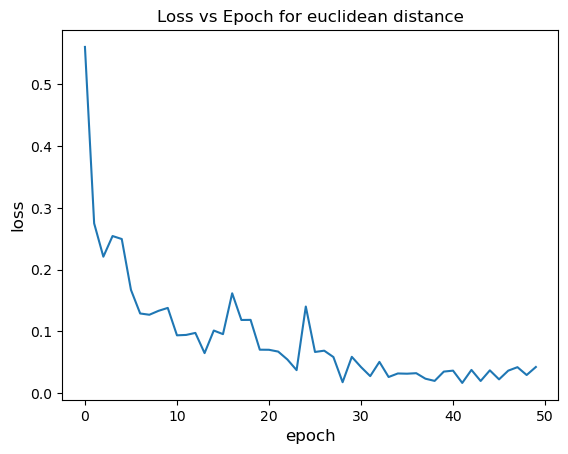

In [12]:

# Plotting the loss vs epoch
plt.figure()
plt.title('Loss vs Epoch for euclidean distance')
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
counter = list(range(50))
show_plot(counter, losses)

In [11]:
#### here we create dataiter for test

# Locate the test dataset and load it into the SiameseNetworkDataset_for_test
if testing:
    test_dataloader,_ = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)

    # Grab one image that we are going to test
    dataiter = iter(test_dataloader)
    x0,_ = next(dataiter)


    #### here we create dataiter for train.

    # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
    train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)

    dataiter_train = iter(train_dataloader)

    score = []

    for i in range(len(siamese_dataset_train)):
        # Iterate over all images and test them with the first image (x0)
        x1,_ = next(dataiter_train)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)
        
        output1, output2 = net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        score.append(round(euclidean_distance.item(),2))
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
        # cosine_distance = torch.cosine_similarity(output1, output2)
        # score.append(round(cosine_distance.item(),2))
        # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {cosine_distance.item():.2f}')

Now we test all the test images with all the train images and all combination are unique.

In [18]:
#### here we create dataiter for test

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)

#### here we create dataiter for train

train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)


truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]
count_label0 = []
count_label1 = []

count = 0
dataiter = iter(test_dataloader)
for i in range(len(siamese_dataset)):
    
    x0,label0 = next(dataiter)
    count_label0.append(label0)
    

# Grab one image that we are going to test
    dataiter_train = iter(train_dataloader)

    for i in range(len(siamese_dataset_train)):
    # Iterate over 5 images and test them with the first image (x0)
        x1,label1 = next(dataiter_train)
        count_label1.append(label1)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)

        output1, output2 = model(x0, x1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        

        predict.append(euclidean_distance.item())
        if label0==label1: # if labels of two images are same append them to same_dissimilar
            same_disssimilarity.append(euclidean_distance.item())
        else:
            different_disssimilarity.append(euclidean_distance.item())
        count+=1
        print(count) # 22200

        # cosine_distance = torch.cosine_similarity(output1, output2)
        # predict.append(cosine_distance.item())
        # if label0==label1:
        #     same_disssimilarity.append(cosine_distance.item())
        # else:
        #     different_disssimilarity.append(cosine_distance.item())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
# checking if there are any intersection in same and different images
print("Number of total interesection: ", len(intersection(same_disssimilarity,different_disssimilarity)))

Number of total interesection:  2503


/var/folders/b_/gqzx0vk107q2kdc69ybxh9pw0000gn/T/ipykernel_74328/3183135136.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(same_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Same", color=colors[0])
/var/folders/b_/gqzx0vk107q2kdc69ybxh9pw0000gn/T/ipykernel_74328/3183135136.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https:

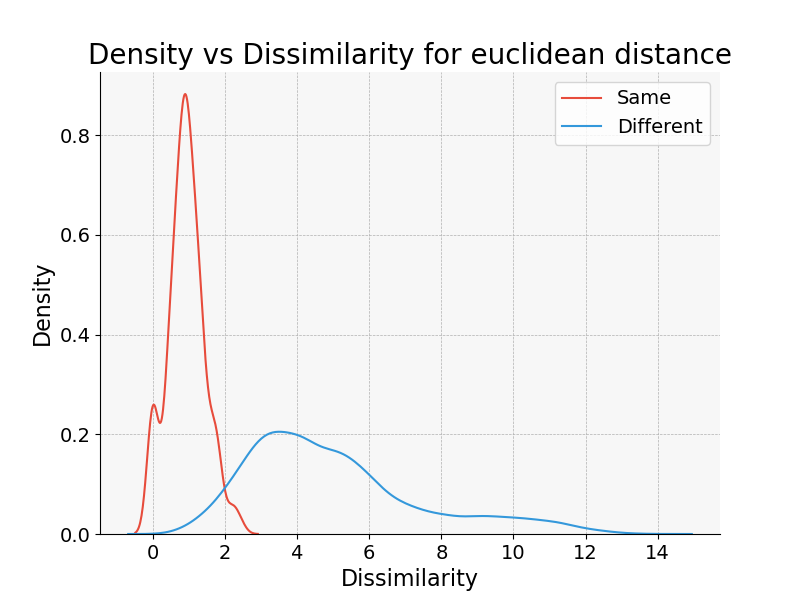

In [26]:
# Plotting the distribution for same vs dissimilar images density plot

%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt

# Set custom color palette
colors = ["#E74C3C", "#3498DB"]

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Set background color
ax.set_facecolor("#F7F7F7")

# Plot the distributions and set custom colors
sns.distplot(same_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Same", color=colors[0])
sns.distplot(different_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Different", color=colors[1])

# Add legend and title
plt.legend(fontsize=14)
plt.title('Density vs Dissimilarity for euclidean distance', fontsize=20)

# Add gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Set axis labels and tick sizes
plt.xlabel("Dissimilarity", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()

In [21]:
# checking for mean/average score
from statistics import mean
print("Mean of same images: ",mean(same_disssimilarity))
print("Mean of different images: ",mean(different_disssimilarity))

Mean of same images:  0.9203537123157245
Mean of different images:  4.987222000839504


In [22]:
# Prinitng total number of combinations that we tested on
print("Total number of combinations of same images: ", len(same_disssimilarity))
print("Total number of combinations of different images: ", len(different_disssimilarity))
print("Total number of combinations: ", len(same_disssimilarity) + len(different_disssimilarity))

Total number of combinations of same images:  300
Total number of combinations of different images:  21900
Total number of combinations:  22200


In [23]:
# Checking for number of missclassified images
final_list, same_misclassified, different_misclassified = threshold(same_disssimilarity,different_disssimilarity,0.25)

print("Total number of missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(final_list))
print("Total number of same class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(same_misclassified))
print("Total number of different class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(different_misclassified))

Total number of missclassified for threshold score  0.3  missclassified images:  270
Total number of same class missclassified for threshold score  0.3  missclassified images:  270
Total number of different class missclassified for threshold score  0.3  missclassified images:  0


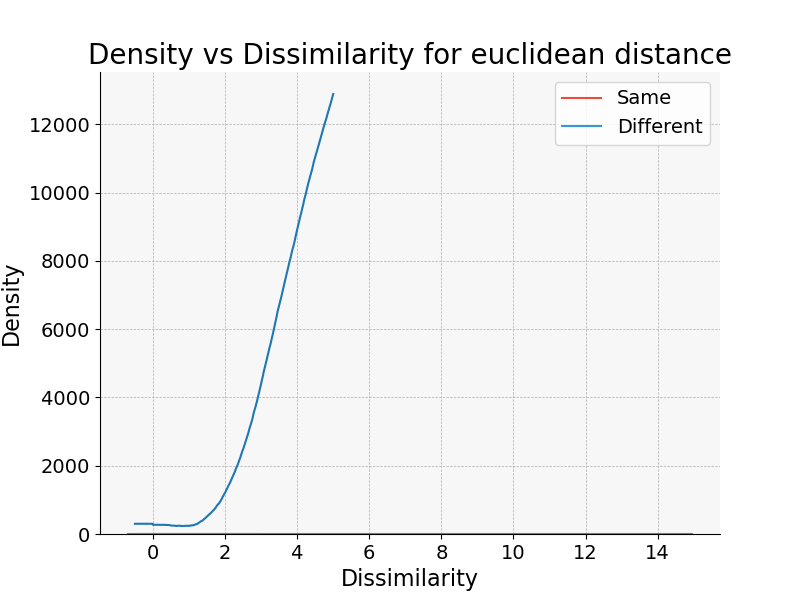

In [24]:
import numpy as np
final_list_1 = {}
for i in np.linspace(-0.5,5,550):
    x,_,_ = threshold(same_disssimilarity,different_disssimilarity,i)
    final_list_1[i] = len(x)

plt.plot(final_list_1.keys(),final_list_1.values())

plt.show()